Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Config

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/Colab\ Notebooks/mest

/content/drive/MyDrive/Colab Notebooks/mest


# Библиотеки

In [ ]:
# from hydra import compose, initialize
# from omegaconf import OmegaConf
# import matplotlib.pyplot as plt

# from torchvision import datasets, models, transforms
# from time import time
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
from torchvision import models, transforms, utils
from torchvision.transforms import v2

# from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
# import torch
import os, json, cv2, re
import numpy as np

# from src.dataset import My_Dataset, TripletDataset, Emb_Dataset
# from src.functions import number_of_parameters, seed_everything, create_model
# from src.dataset_fun import split_dataset
# from src import siamese, classifier
# from src.classifier import get_predictions
# from src.train import train, load_logs, load_model
# from src.functions import confusion_matrix, distribution
# from src.show_fun import show_result, show_images

# kraken

In [ ]:
!pip install kraken

In [ ]:
LINES = "lines"
LINES_POS = f"{LINES}/1"
LINES_NEG = f"{LINES}/0"

DATA = "data"
DATA_POS = f"{DATA}/1"
DATA_NEG = f"{DATA}/0"

STROKES = "strokes"
!mkdir "$STROKES"

mkdir: cannot create directory ‘strokes’: File exists


In [ ]:
pic_names = sorted(os.listdir(DATA_POS))
pic_names

['1 Ранний почерк-(обычный почерк).jpg',
 '1 Ранний почерк-(хороший почерк)-0.jpg',
 '1 Ранний почерк-(хороший почерк)-1.jpg',
 '1 Ранний почерк-(хороший почерк)-2.jpg',
 '1 Ранний почерк-(хороший почерк)-3.jpg',
 '2 Зрелый почерк-(Вяземскому? плохой почерк)-0.jpg',
 '2 Зрелый почерк-(Вяземскому? плохой почерк)-1.jpg',
 '2 Зрелый почерк-(идеальный почерк)-0.jpeg',
 '2 Зрелый почерк-(идеальный почерк)-1.jpeg',
 '2 Зрелый почерк-(идеальный почерк)-2.jpeg',
 '2 Зрелый почерк-(идеальный почерк)-3.jpeg',
 '2 Зрелый почерк-(обычный почерк)-0.jpg',
 '2 Зрелый почерк-(обычный почерк)-1.jpg',
 '2 Зрелый почерк-(плохой почерк).jpg',
 '3 Поздний почерк-(обычный почерк).jpg',
 '3 Поздний почерк-(плохой почерк)-0.jpg',
 '3 Поздний почерк-(плохой почерк)-1.jpg',
 '3 Поздний почерк-(плохой почерк)-2.jpg',
 '3 Поздний почерк-(хороший почерк)-0.JPG',
 '3 Поздний почерк-(хороший почерк)-1.JPG',
 '3 Поздний почерк-(хороший почерк)-2.JPG',
 '3 Поздний почерк-(хор

In [ ]:
inds = [LINES_POS]

for folder in inds:
    # lst = glob(folder+'/letter*', recursive=True)
    files_names = sorted(os.listdir(folder))
    lst = [os.path.join(folder, i) for i in files_names]
    # получаем список путей до изображений что надо сегментировать.
    # У меня в самих директориях лежит много хлама помимо нужных картинок,
    # поэтому я сделал так что у меня все нужные изображения содержат в названии
    # общий элемент 'letter', по которому их можно вытянуть с помощью функции glob.
    # Можно сделать и по-другому, главное - получить список изображений в данной директории.
    for jsonpic in lst:
        # print(jsonpic)
        # name, ext = os.path.splitext(picture)
        splitjson = re.split(r"/", jsonpic)
        splitjson[0] = DATA
        splitjson[1] = "1"

        name, ext = os.path.splitext(splitjson[2])

        for i in sorted(os.listdir(DATA_POS)):
            if i.startswith(name):
                image_name = i

        splitjson[2] = image_name
        image = "/".join(splitjson)

        print(image)
        splitname[0] = LINES
        new_picture = os.path.join(*splitname) + '.json'
        os.system("kraken -i '{}' '{}' segment -bl".format(picture, new_picture))
        print(f"--- Сonversion of    '{picture}'\n               to    '{new_picture}' ---\n")

        # запуск программы. на выходе получается из изображения файл с таким же именем
        # но расширением json

        f = open(jsonpic)

        json_object = json.load(f)
        tt = cv2.imread(image)
        num = 0
        for obj in json_object['lines']:
            # итерируемся по всем получившимся многоугольникам, ограничивающим строки
            image = []
            for i in range(3):# изображение - 3 канала
                img = tt[:,:,i]
                pts = np.array(obj['boundary'])
                rect = cv2.boundingRect(pts)
                # минимальный прямоугольник, содержащий рассматриваемый многоугольник
                x,y,w,h = rect
                croped = img[y:y+h, x:x+w].copy() # вырезаем прямоугольник
                pts = pts - pts.min(axis=0)
                mask = np.zeros(croped.shape[:2], np.uint8)
                cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
                dst = cv2.bitwise_and(croped, croped, mask=mask)
                # заливаем нулями все что попало в прямотугольник
                # но не попало в многоугольник
                bg = np.ones_like(croped, np.uint8)*255
                cv2.bitwise_not(bg,bg, mask=mask)
                # 0 - черный цвет. надо белый. Превращаем 0 в 1
                dst2 = bg+ dst
                image.append(dst2[:,:,None])

            result = np.concatenate(image,2)

            name, ext = os.path.splitext(image_name)
            name += f"|{num}|"
            name = os.path.join(STROKES, name + ext)
            cv2.imwrite(name, result)
            print(name)
            num += 1

strokes/1 Ранний почерк-(обычный почерк)|0|.jpg
strokes/1 Ранний почерк-(обычный почерк)|1|.jpg
strokes/1 Ранний почерк-(обычный почерк)|2|.jpg
strokes/1 Ранний почерк-(обычный почерк)|3|.jpg
strokes/1 Ранний почерк-(обычный почерк)|4|.jpg
strokes/1 Ранний почерк-(обычный почерк)|5|.jpg
strokes/1 Ранний почерк-(обычный почерк)|6|.jpg
strokes/1 Ранний почерк-(обычный почерк)|7|.jpg
strokes/1 Ранний почерк-(обычный почерк)|8|.jpg
strokes/1 Ранний почерк-(обычный почерк)|9|.jpg
strokes/1 Ранний почерк-(обычный почерк)|10|.jpg
strokes/1 Ранний почерк-(обычный почерк)|11|.jpg
strokes/1 Ранний почерк-(обычный почерк)|12|.jpg
strokes/1 Ранний почерк-(обычный почерк)|13|.jpg
strokes/1 Ранний почерк-(обычный почерк)|14|.jpg
strokes/1 Ранний почерк-(обычный почерк)|15|.jpg
strokes/1 Ранний почерк-(обычный почерк)|16|.jpg
strokes/1 Ранний почерк-(обычный почерк)|17|.jpg
strokes/1 Ранний почерк-(обычный почерк)|18|.jpg
strokes/1 Ранний почерк-(обычный почерк

# IAM

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"natalkapronina","key":"92ca5421679d5dd21eca62d1a1e14456"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 May 29 09:43 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pwd

/content


In [ ]:
 !kaggle datasets list

ref                                                        title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rohit265/credit-card-eligibility-data-determining-factors  Credit Card Eligibility Data: Determining Factors  296KB  2024-05-18 11:31:28            912         23  1.0              
rahulvyasm/netflix-movies-and-tv-shows                     Netflix Movies and TV Shows                          1MB  2024-04-10 09:48:38          25601        548  1.0              
mayankanand2701/netflix-stock-price-dataset                Netflix Stock Price Dataset 🎥🍿🎬📊                   107KB  2024-05-25 06:59:35            654         31  1.0              
prasad22/weather-data                                      Weather Data                   

In [ ]:
! kaggle datasets download -d naderabdalghani/iam-handwritten-forms-dataset

Dataset URL: https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset
License(s): unknown
100% 4.29G/4.31G [01:01<00:00, 122MB/s]
100% 4.31G/4.31G [01:01<00:00, 75.1MB/s]


In [ ]:
!unzip iam-handwritten-forms-dataset.zip

Archive:  iam-handwritten-forms-dataset.zip
  inflating: __notebook_source__.ipynb  
  inflating: data/000/a01-000u.png   
  inflating: data/000/a01-003u.png   
  inflating: data/000/a01-007u.png   
  inflating: data/000/a01-011u.png   
  inflating: data/000/a01-014u.png   
  inflating: data/000/a01-020u.png   
  inflating: data/000/a01-026u.png   
  inflating: data/000/a01-030u.png   
  inflating: data/000/a01-043u.png   
  inflating: data/000/a01-049u.png   
  inflating: data/000/a01-049x.png   
  inflating: data/000/a01-053u.png   
  inflating: data/000/a01-058u.png   
  inflating: data/000/a01-063u.png   
  inflating: data/000/a01-068u.png   
  inflating: data/000/a01-072u.png   
  inflating: data/000/a01-077u.png   
  inflating: data/000/a01-082u.png   
  inflating: data/000/a01-087u.png   
  inflating: data/000/a01-091u.png   
  inflating: data/000/a01-096u.png   
  inflating: data/000/a01-102u.png   
  inflating: data/000/a01-107u.png   
  inflating: data/000/a01-113u.png   
  i

# transform

In [ ]:
from PIL import Image, ImageOps

data/496/l07-080.png torch.Size([500, 565, 3])


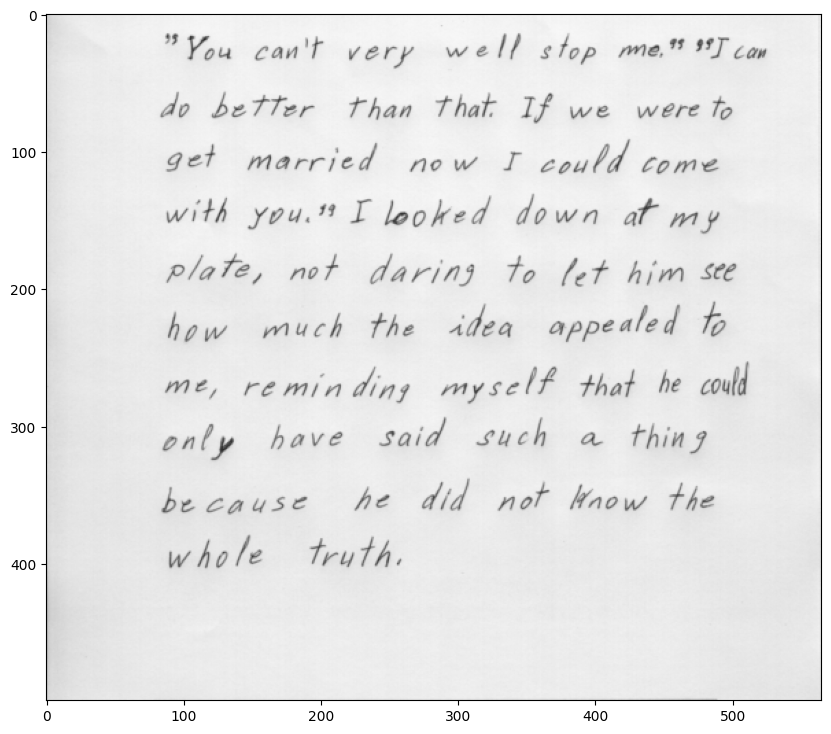

data/496/l07-085.png torch.Size([500, 565, 3])


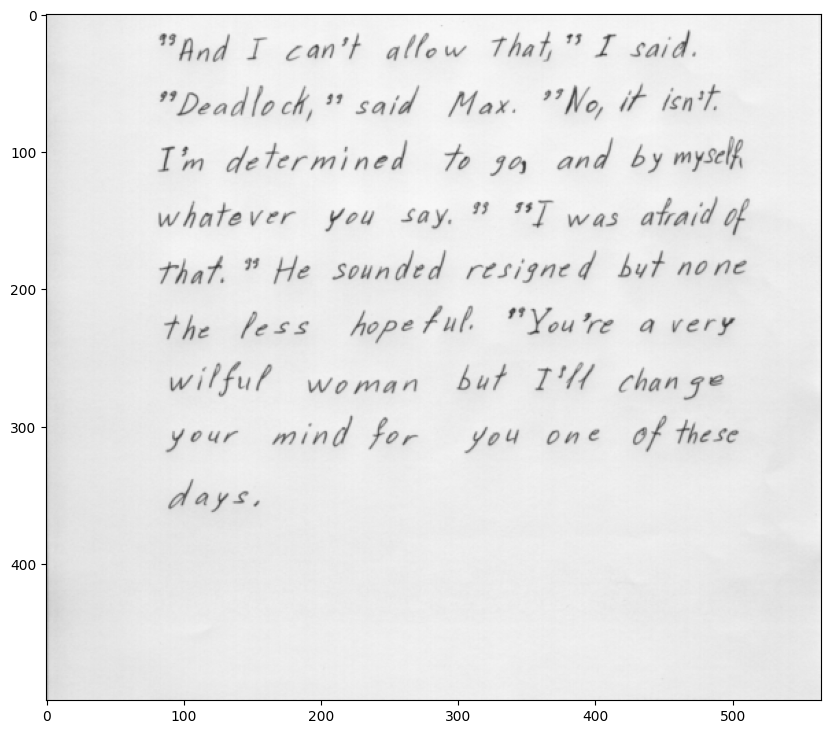

data/496/l07-103.png torch.Size([500, 565, 3])


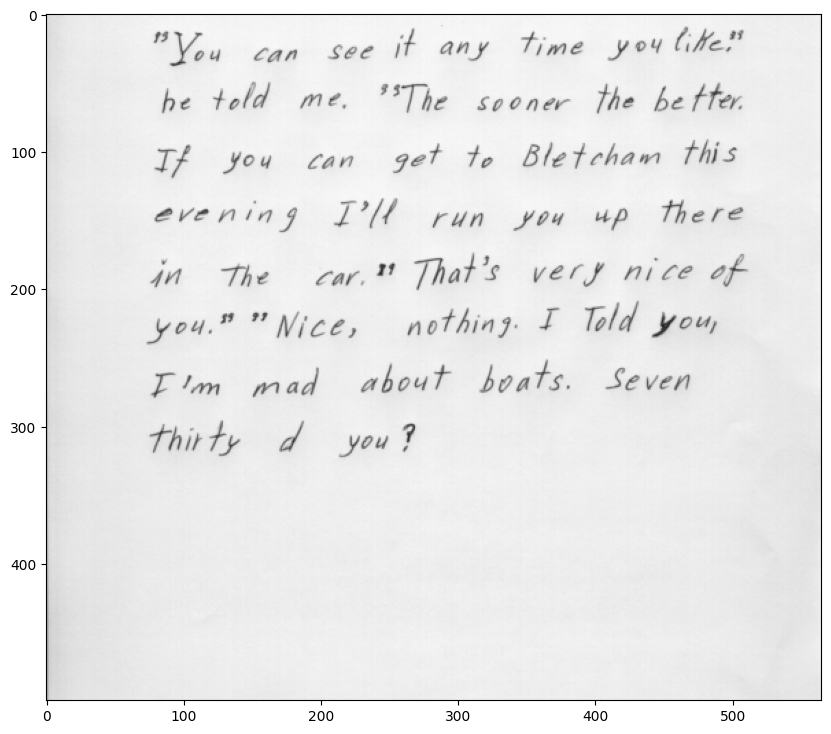

data/496/l07-111.png torch.Size([500, 565, 3])


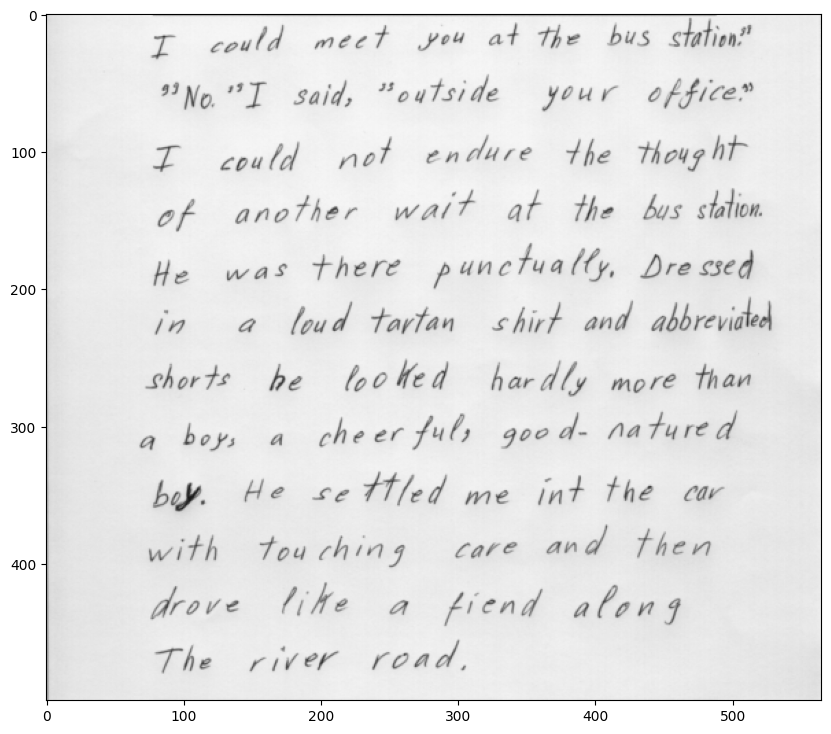

In [ ]:
for dirpath, dirnames, filenames in os.walk("data/496"):

    for fname in sorted(filenames):
        fpath = os.path.join(dirpath, fname)

        f = Image.open(fpath)
        transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        v2.functional.grayscale_to_rgb])


        transformed_image = transform(f)

        top = 610
        bottom = 740
        transformed_image = transforms.functional.crop(transformed_image,
            top = top, left = 0, height = 3542 - top - bottom, width = 2479)

        transformed_image = transforms.Resize(500)(transformed_image)

        transformed_image = transformed_image.permute(1, 2, 0)

        print(fpath, transformed_image.shape)
        plt.figure(figsize=(10, 10))
        plt.imshow(transformed_image)
        plt.show()

# bin

In [ ]:
! pip install replicate

In [ ]:
%time
import os
import replicate

os.environ["REPLICATE_API_TOKEN"] = "r8_9UdJxB5uWziBkS1FtwvQ37WfOoyxp5c0rXQrR"
api = replicate.Client(api_token=os.environ["REPLICATE_API_TOKEN"])


image = "https://replicate.delivery/mgxm/7bb1c92e-0b30-4107-9a95-5b8f0040a80e/14.png"

input={
    "image": image,
    "model_size": "base",
    }

output = api.run(
    "cjwbw/docentr:0bc456216d675a98405175bf49f2123a6e32a52e0d6a00159edf3f3dc010fa09",
    input=input
)
print(output)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.82 µs


ReplicateError: ReplicateError Details:
title: Unauthenticated
status: 401
detail: You did not pass a valid authentication token

# dataset

In [ ]:
! mkdir dataset

In [ ]:
for dirpath, dirnames, filenames in os.walk("data"):

    for fname in sorted(filenames):
        fpath = os.path.join(dirpath, fname)

        f = Image.open(fpath)
        transform = transforms.Compose([transforms.ToTensor(),
                                        v2.functional.grayscale_to_rgb])


        transformed_image = transform(f)

        top = 610
        bottom = 740
        transformed_image = transforms.functional.crop(transformed_image,
            top = top, left = 0, height = 3542 - top - bottom, width = 2479)

        transformed_image = transforms.Resize(500)(transformed_image)
        # transformed_image = transformed_image.permute(1, 2, 0)

        fpath = re.split(r"/", fpath)
        fpath[0] = "dataset"

        dir = os.path.join(fpath[0], fpath[1])
        if not os.path.exists(dir):
            os.makedirs(dir)

        fpath = os.path.join(*fpath)
        print(f"{fpath:30},    {transformed_image.shape}")

        utils.save_image(transformed_image, fpath)

dataset/085/a06-124.png       ,    torch.Size([3, 500, 565])
dataset/085/a06-134.png       ,    torch.Size([3, 500, 565])
dataset/085/a06-141.png       ,    torch.Size([3, 500, 565])
dataset/085/a06-147.png       ,    torch.Size([3, 500, 565])
dataset/085/a06-157.png       ,    torch.Size([3, 500, 565])
dataset/085/e07-000.png       ,    torch.Size([3, 500, 565])
dataset/001/a01-000x.png      ,    torch.Size([3, 500, 565])
dataset/001/a01-072x.png      ,    torch.Size([3, 500, 565])
dataset/496/l07-080.png       ,    torch.Size([3, 500, 565])
dataset/496/l07-085.png       ,    torch.Size([3, 500, 565])
dataset/496/l07-103.png       ,    torch.Size([3, 500, 565])
dataset/496/l07-111.png       ,    torch.Size([3, 500, 565])
dataset/019/a01-117.png       ,    torch.Size([3, 500, 565])
dataset/019/a01-122.png       ,    torch.Size([3, 500, 565])
dataset/019/a01-128.png       ,    torch.Size([3, 500, 565])
dataset/513/m01-104.png       ,    torch.Size([3, 500, 565])
dataset/513/m01-121.png 

In [ ]:
!zip -r dataset.zip dataset

  adding: dataset/ (stored 0%)
  adding: dataset/085/ (stored 0%)
  adding: dataset/085/a06-147.png (deflated 1%)
  adding: dataset/085/e07-000.png (deflated 1%)
  adding: dataset/085/a06-134.png (deflated 2%)
  adding: dataset/085/a06-141.png (deflated 1%)
  adding: dataset/085/a06-157.png (deflated 1%)
  adding: dataset/085/a06-124.png (deflated 2%)
  adding: dataset/001/ (stored 0%)
  adding: dataset/001/a01-072x.png (deflated 1%)
  adding: dataset/001/a01-000x.png (deflated 1%)
  adding: dataset/496/ (stored 0%)
  adding: dataset/496/l07-085.png (deflated 2%)
  adding: dataset/496/l07-080.png (deflated 2%)
  adding: dataset/496/l07-103.png (deflated 2%)
  adding: dataset/496/l07-111.png (deflated 2%)
  adding: dataset/019/ (stored 0%)
  adding: dataset/019/a01-122.png (deflated 3%)
  adding: dataset/019/a01-128.png (deflated 3%)
  adding: dataset/019/a01-117.png (deflated 3%)
  adding: dataset/513/ (stored 0%)
  adding: dataset/513/m01-121.png (deflated 2%)
  adding: dataset/513/m0

In [ ]:
!du -h "dataset.zip"

258M	dataset.zip


In [ ]:
!du -h "dataset_total.zip"

4.2G	dataset_total.zip


In [ ]:
!du -h "iam-handwritten-forms-dataset.zip"

4.4G	iam-handwritten-forms-dataset.zip


In [ ]:
dirs = []
l = 0

for dirpath, dirnames, filenames in os.walk("data"):
    l += len(filenames)
    for f in filenames:
        name = os.path.join(dirpath, f)
        !du -h "$name"

3.2M	data/085/a06-147.png
3.8M	data/085/e07-000.png
2.9M	data/085/a06-134.png
3.4M	data/085/a06-141.png
2.8M	data/085/a06-157.png
3.0M	data/085/a06-124.png
4.8M	data/001/a01-072x.png
4.9M	data/001/a01-000x.png
5.0M	data/496/l07-085.png
5.0M	data/496/l07-080.png
4.9M	data/496/l07-103.png
5.1M	data/496/l07-111.png
2.2M	data/019/a01-122.png
2.2M	data/019/a01-128.png
2.2M	data/019/a01-117.png
3.4M	data/513/m01-121.png
3.9M	data/513/m01-104.png
4.6M	data/223/e02-074.png
2.2M	data/027/a02-046.png
2.0M	data/087/b01-009.png
2.2M	data/087/b01-004.png
2.0M	data/087/b01-000.png
3.7M	data/470/l01-157.png
536K	data/618/p03-033.png
^C
3.0M	data/477/l03-004.png
3.3M	data/499/m01-000.png
1.2M	data/120/b05-079.png
3.9M	data/516/m01-125.png
552K	data/615/p03-023.png
3.4M	data/310/g03-016.png
1.7M	data/665/r03-084.png
3.8M	data/132/b06-082.png
4.1M	data/132/b06-045.png
3.9M	data/132/c06-047.png
3.5M	data/132/c06-091.png
1.1M	data/352/g07-028b.png
1004K	data/352/g07-022b.png
880K	data/352/g07-034.png
1012

In [ ]:
dirs = []
l = 0

for dirpath, dirnames, filenames in os.walk("dataset"):
    l += len(filenames)
    for f in filenames:
        name = os.path.join(dirpath, f)
        !du -h "$name"

136K	dataset/085/a06-147.png
148K	dataset/085/e07-000.png
128K	dataset/085/a06-134.png
140K	dataset/085/a06-141.png
108K	dataset/085/a06-157.png
124K	dataset/085/a06-124.png
184K	dataset/001/a01-072x.png
180K	dataset/001/a01-000x.png
204K	dataset/496/l07-085.png
212K	dataset/496/l07-080.png
196K	dataset/496/l07-103.png
224K	dataset/496/l07-111.png
184K	dataset/019/a01-122.png
200K	dataset/019/a01-128.png
204K	dataset/019/a01-117.png
184K	dataset/513/m01-121.png
196K	dataset/513/m01-104.png
196K	dataset/223/e02-074.png
196K	dataset/027/a02-046.png
136K	dataset/087/b01-009.png
148K	dataset/087/b01-004.png
136K	dataset/087/b01-000.png
168K	dataset/470/l01-157.png
80K	dataset/618/p03-033.png
180K	dataset/643/r02-060.png
156K	dataset/477/l03-004.png
172K	dataset/499/m01-000.png
168K	dataset/120/b05-079.png
192K	dataset/516/m01-125.png
84K	dataset/615/p03-023.png
224K	dataset/310/g03-016.png
240K	dataset/665/r03-084.png
224K	dataset/132/b06-082.png
220K	dataset/132/b06-045.png
200K	dataset/1

# result

In [ ]:
dirs_more_one = []
l = 0

for dirpath, dirnames, filenames in os.walk("dataset"):
    l += len(filenames)
    if len(filenames) > 1:
        dirs_more_one.append(dirpath)

In [ ]:
l

1539

In [ ]:
dirs_more_one

['dataset/085',
 'dataset/001',
 'dataset/496',
 'dataset/019',
 'dataset/513',
 'dataset/087',
 'dataset/132',
 'dataset/352',
 'dataset/212',
 'dataset/250',
 'dataset/324',
 'dataset/090',
 'dataset/155',
 'dataset/109',
 'dataset/561',
 'dataset/583',
 'dataset/188',
 'dataset/213',
 'dataset/111',
 'dataset/242',
 'dataset/347',
 'dataset/343',
 'dataset/273',
 'dataset/192',
 'dataset/546',
 'dataset/235',
 'dataset/559',
 'dataset/168',
 'dataset/259',
 'dataset/483',
 'dataset/016',
 'dataset/247',
 'dataset/239',
 'dataset/353',
 'dataset/329',
 'dataset/209',
 'dataset/384',
 'dataset/382',
 'dataset/482',
 'dataset/495',
 'dataset/153',
 'dataset/356',
 'dataset/453',
 'dataset/585',
 'dataset/415',
 'dataset/084',
 'dataset/127',
 'dataset/230',
 'dataset/108',
 'dataset/139',
 'dataset/455',
 'dataset/351',
 'dataset/380',
 'dataset/275',
 'dataset/165',
 'dataset/133',
 'dataset/335',
 'dataset/272',
 'dataset/010',
 'dataset/548',
 'dataset/635',
 'dataset/498',
 'datase